In [1]:
!pip install numpy

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=51ffcb4e8bf2ebc5815526737969ebc889860b0d8245840fbed3de0d9f7325c1
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [82]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import pandas as pd
import numpy as np

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

In [5]:
df = pd.read_csv('cleaned-RecommendationSystem.csv')


In [55]:
print(len(df))

257183


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df.head()

,customer_id,product_id,quantity,purchased_date_time,gender,city,product_name,product_description,category,category_id,age,month_year
0,5e1024dd1212410001218ff2,5e0db9197bb5cb00011dbc91,1.0,2020-01-04 06:52:44.284000+00:00,Unknown,Unknown,2 Piece Double Layer Hot Bag,<p>This is a high-quality hot water bag with F...,Hot Pack/Ice Bag,5d7b236ff31472000142fd6b,36.0,2020-01
1,5e1024dd1212410001218ff2,5e0db9197bb5cb00011dbc91,1.0,2020-01-04 06:52:44.284000+00:00,Unknown,Unknown,2 Piece Double Layer Hot Bag,<p>This is a high-quality hot water bag with F...,Orthopaedics,5d7b22bef31472000142d4b5,36.0,2020-01
2,5e1024dd1212410001218ff2,5e0db9197bb5cb00011dbc91,1.0,2020-01-04 06:52:44.284000+00:00,Unknown,Unknown,2 Piece Double Layer Hot Bag,<p>This is a high-quality hot water bag with F...,Devices,5d2dc23e0faaef000152a107,36.0,2020-01
3,5e11652179c7eb0001b09b21,5e0db9197bb5cb00011dbc91,1.0,2020-01-05 11:32:52.649000+00:00,Unknown,Unknown,2 Piece Double Layer Hot Bag,<p>This is a high-quality hot water bag with F...,Hot Pack/Ice Bag,5d7b236ff31472000142fd6b,33.0,2020-01
4,5e11652179c7eb0001b09b21,5e0db9197bb5cb00011dbc91,1.0,2020-01-05 11:32:52.649000+00:00,Unknown,Unknown,2 Piece Double Layer Hot Bag,<p>This is a high-quality hot water bag with F...,Orthopaedics,5d7b22bef31472000142d4b5,33.0,2020-01


In [7]:
# Create a user-item matrix for recommendation
reader = Reader(rating_scale=(1, df['quantity'].max()))
data = Dataset.load_from_df(df[['customer_id', 'product_id', 'quantity']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [8]:
# Train a Singular Value Decomposition (SVD) model
model = SVD()
model.fit(trainset)

### 1. Predicts the products that a customer is likely to purchase based on their past interactions.

In [93]:
def predict_products(customer_id, n_recommendations=5):
    # Get the products purchased by the customer
    customer_purchases = df[df['customer_id'] == customer_id][['product_id', 'product_name']].drop_duplicates()
    print(f"Products already purchased by Customer {customer_id}:")
    print(customer_purchases.to_markdown(index=False))

    # Get all products and identify unpurchased products
    all_products = set(df['product_id'])
    purchased_products = set(customer_purchases['product_id'])
    unpurchased_products = list(all_products - purchased_products)

    # Predict scores for unpurchased products
    predictions = [
        (product_id, model.predict(customer_id, product_id).est)
        for product_id in unpurchased_products
    ]
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    # Get recommended product names and prediction scores
    recommended_product_ids = [p[0] for p in predictions]
    predicted_scores = [p[1] for p in predictions]
    recommended_products = df[df['product_id'].isin(recommended_product_ids)][['product_id', 'product_name']].drop_duplicates()

    # Add predicted scores to the DataFrame
    recommended_products['predicted_score'] = predicted_scores

    return recommended_products

# Example usage
customer_id = '5e1024dd1212410001218ff2'
recommended_products = predict_products(customer_id)

print("\n\nRecommended products:")
print(recommended_products.to_markdown(index=False))


Products already purchased by Customer 5e1024dd1212410001218ff2:
| product_id               | product_name                 |
|:-------------------------|:-----------------------------|
| 5e0db9197bb5cb00011dbc91 | 2 Piece Double Layer Hot Bag |
| 5e01ed314629120001320f1a | Dudrops Eye Drops 10ml       |
| 5ed787822942440001b9f687 | Cal-K7 Capsule 30'Bottle     |
| 5ed787822942440001ba0bee | Omocid 20mg 10'S             |
| 5e01ed284629120001320c7c | Aztor 10 Tablet 15'S         |


Recommended products:
| product_id               | product_name                                                                       |   predicted_score |
|:-------------------------|:-----------------------------------------------------------------------------------|------------------:|
| 5e01fb3d4629120001328441 | Pee Safe 100% Organic Cotton, Biodegradable Sanitary Pads - Overnight (Pack of 10) |                 6 |
| 618cc0bf9e0960083772578b | COSRX Aloe Soothing Sun Cream SPF50 PA+++ 50ml              

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


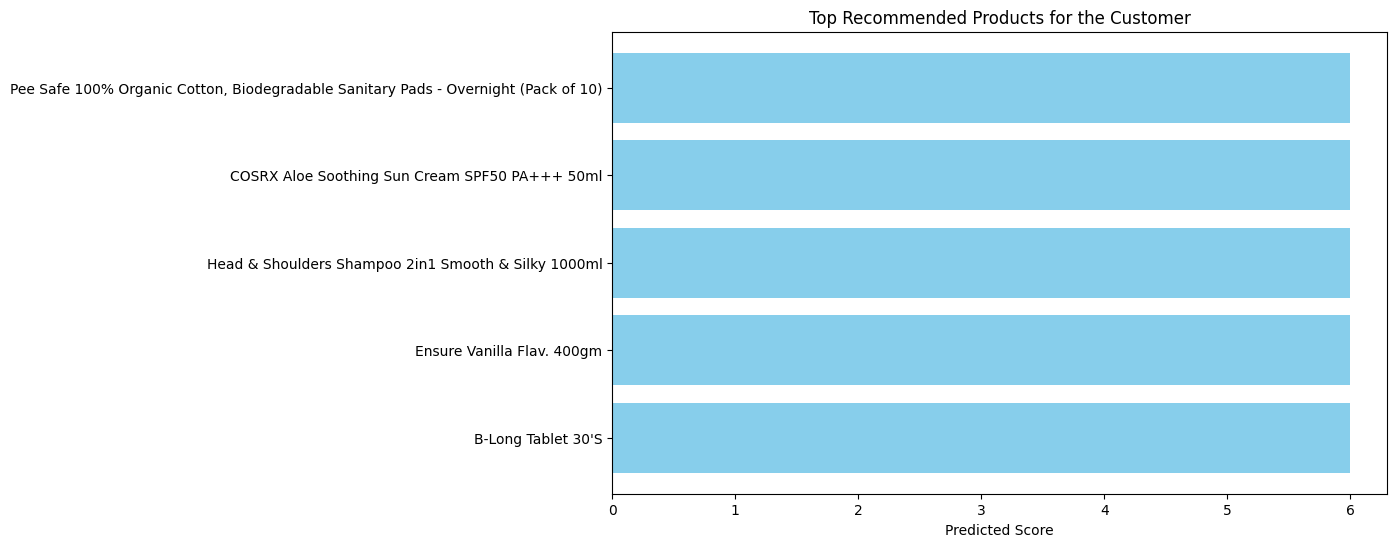

In [76]:
import matplotlib.pyplot as plt

def visualize_recommendations(recommended_products):
    # Check if the recommended products DataFrame contains predicted scores
    if 'predicted_score' in recommended_products.columns:
        # Sort the products based on predicted scores
        recommended_products = recommended_products.sort_values(by='predicted_score', ascending=False)

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        plt.barh(recommended_products['product_name'], recommended_products['predicted_score'], color='skyblue')
        plt.xlabel('Predicted Score')
        plt.title('Top Recommended Products for the Customer')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
        plt.show()
    else:
        print("No predicted scores found in the recommended products.")

visualize_recommendations(recommended_products)


### 2. Find uncommon products that a customer has purchased compared to other customers.

In [94]:
def find_uncommon_products(customer_id, data):
    customer_products = set(data[data['customer_id'] == customer_id]['product_id'])
    other_products = set(data[data['customer_id'] != customer_id]['product_id'])
    uncommon_products = customer_products - other_products

    uncommon_product_details = data[data['product_id'].isin(uncommon_products)][['product_id', 'product_name']].drop_duplicates()
    return uncommon_product_details

# Example usage
customer_id = '5e1024dd1212410001218ff2'
uncommon_products = find_uncommon_products(customer_id, df)

print(f"Customer ID: {customer_id}")
print(f"Total products purchased by the customer: {len(set(df[df['customer_id'] == customer_id]['product_id']))}")
print(f"Uncommon products purchased by the customer (not purchased by others): {len(uncommon_products)}\n")

print("------------------------------------------------------")
if not uncommon_products.empty:
    print("List of uncommon products purchased by the customer:")
    print(uncommon_products.to_markdown(index=False))
else:
    print("No uncommon products found for this customer.")


Customer ID: 5e1024dd1212410001218ff2
Total products purchased by the customer: 5
Uncommon products purchased by the customer (not purchased by others): 1

------------------------------------------------------
List of uncommon products purchased by the customer:
| product_id               | product_name     |
|:-------------------------|:-----------------|
| 5ed787822942440001ba0bee | Omocid 20mg 10'S |


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


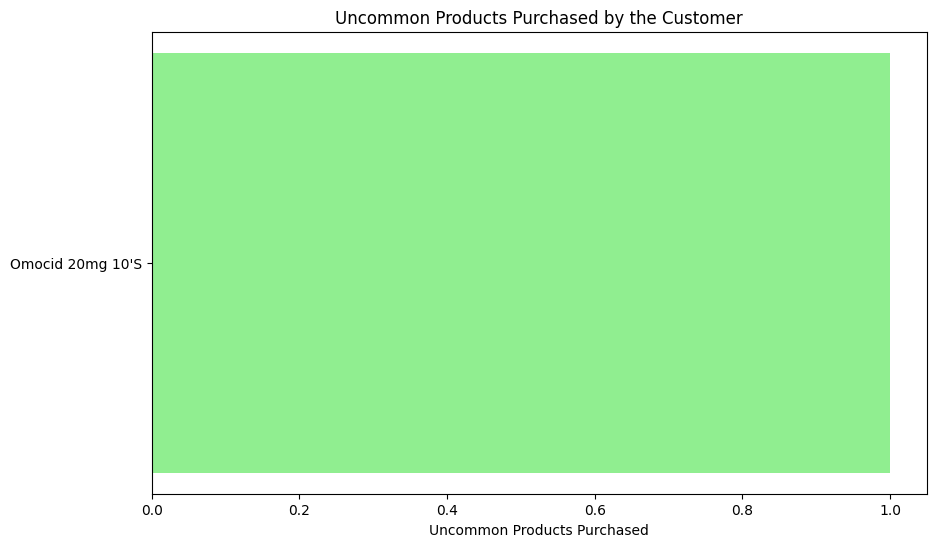

In [74]:
import matplotlib.pyplot as plt

def visualize_uncommon_products(uncommon_products):
    if not uncommon_products.empty:
        # Get the product names and their counts
        product_names = uncommon_products['product_name']
        product_count = [1] * len(uncommon_products)  # Each uncommon product counts as 1

        # Create a bar chart
        plt.figure(figsize=(10, 6))
        plt.barh(product_names, product_count, color='lightgreen')
        plt.xlabel('Uncommon Products Purchased')
        plt.title('Uncommon Products Purchased by the Customer')
        plt.gca().invert_yaxis()  # Invert the y-axis to have the highest product at the top
        plt.show()
    else:
        print("No uncommon products found to visualize.")

# Now visualize the uncommon products for a specific customer
visualize_uncommon_products(uncommon_products)


### 3. Get the top trending products within the last 2 months. Find top 25 similar products based on a search term.

In [95]:
from datetime import timedelta

# Determine the maximum purchase date in the dataset
max_date = df['purchased_date_time'].max()

# Calculate the two-month range
two_months_ago = max_date - timedelta(days=60)

# Filter the data for the last two months
recent_data = df[df['purchased_date_time'] >= two_months_ago]

# Aggregate data to get top trending products
top_trending_products = (
    recent_data.groupby(['product_name'], as_index=False)
    .agg({'quantity': 'sum', 'purchased_date_time': 'max'})
    .sort_values(by='quantity', ascending=False)
    .head(10)
)

# Display the results
if not top_trending_products.empty:
    print("Top trending products in the last 2 months (based on dataset max purchase date):")
    print(top_trending_products.to_markdown(index=False))
else:
    print("No trending products found in the last 2 months (based on dataset max purchase date).")


Top trending products in the last 2 months (based on dataset max purchase date):
| product_name              |   quantity | purchased_date_time              |
|:--------------------------|-----------:|:---------------------------------|
| Ecosprin-75 Tablet 14'S   |        290 | 2024-09-22 09:46:02.684000+00:00 |
| Modalert 100 Tablet 10'S  |        175 | 2024-09-25 10:49:46.801000+00:00 |
| Cetamol 500 Tablet 10'S   |        132 | 2024-09-20 09:27:07.203000+00:00 |
| Arbo 25 Tablet 10'S       |        125 | 2024-09-23 09:28:18.331000+00:00 |
| Repace H Tablet 10'S      |        120 | 2024-09-22 09:46:02.684000+00:00 |
| FISH OIL 1000mg OMEGA 3   |        116 | 2024-09-24 11:14:37.173000+00:00 |
| Siptin-M 1000 Tablet 10'S |        105 | 2024-09-23 09:28:18.331000+00:00 |
| Folvin Tablet 10'S        |        105 | 2024-09-24 13:52:28.045000+00:00 |
| Calvit Tablet 10'S        |        105 | 2024-09-22 04:49:55.968000+00:00 |
| Acnetret 20 Capsule 10'S  |         90 | 2024-09-24 10:26:2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


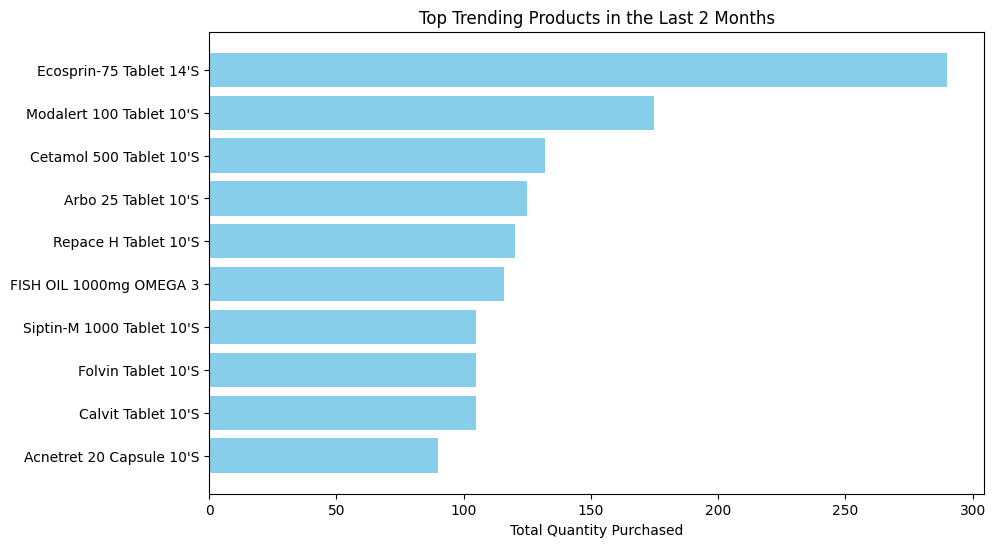

In [65]:
import matplotlib.pyplot as plt

def visualize_trending_products(top_trending_products):
    if not top_trending_products.empty:
        # Plotting the top trending products based on the quantity purchased
        plt.figure(figsize=(10, 6))
        plt.barh(top_trending_products['product_name'], top_trending_products['quantity'], color='skyblue')
        plt.xlabel('Total Quantity Purchased')
        plt.title('Top Trending Products in the Last 2 Months')
        plt.gca().invert_yaxis()  # Invert the y-axis so that the top trending product is at the top
        plt.show()
    else:
        print("No trending products found in the last 2 months.")

# Visualize the top trending products
visualize_trending_products(top_trending_products)


In [79]:
def find_similar_products(search_term, data):
    # Filter products based on the search term (case-insensitive)
    similar_products = data[data['product_name'].str.contains(search_term, case=False, na=False)]

    # Aggregate to get the most recent purchase date for each product
    similar_products_details = (
        similar_products.groupby(['product_id', 'product_name', 'category', 'product_description'], as_index=False)
        .agg({'quantity': 'sum', 'purchased_date_time': 'max'})
    )

    # Sort products by quantity (or other metrics) to find the top ones
    similar_products_details = similar_products_details.sort_values(by='quantity', ascending=False)

    # Get the top 25 similar products
    top_similar_products = similar_products_details.head(25)

    # Return the DataFrame for visualization
    return top_similar_products

# Example usage
search_term = 'Tablet'
top_similar_products = find_similar_products(search_term, df)

# Print the Markdown table
print("Top 25 similar products:")
print(top_similar_products.to_markdown(index=False, numalign="left", colalign="left"))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 25 similar products:
|               product_id |              product_name |                                        category |      product_description | quantity   | purchased_date_time              |
|--------------------------|---------------------------|-------------------------------------------------|--------------------------|:-----------|:---------------------------------|
| 5e3d2697c656250001e066c9 | Asvit Tablet 10'S         | Medicines                                       | No description available | 2976       | 2024-08-26 14:37:11.256000+00:00 |
| 5e12cdb2f471d800013c6a3d | Ecosprin-75 Tablet 14'S   | Aspirin                                         | No description available | 2523       | 2024-09-22 09:46:02.684000+00:00 |
| 5e12cdb2f471d800013c6a3d | Ecosprin-75 Tablet 14'S   | Blood Clot                                      | No description available | 2523       | 2024-09-22 09:46:02.684000+00:00 |
| 5e12cdb2f471d800013c6a3d | Ecosprin-75 Tablet 14'S   | Medicine

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


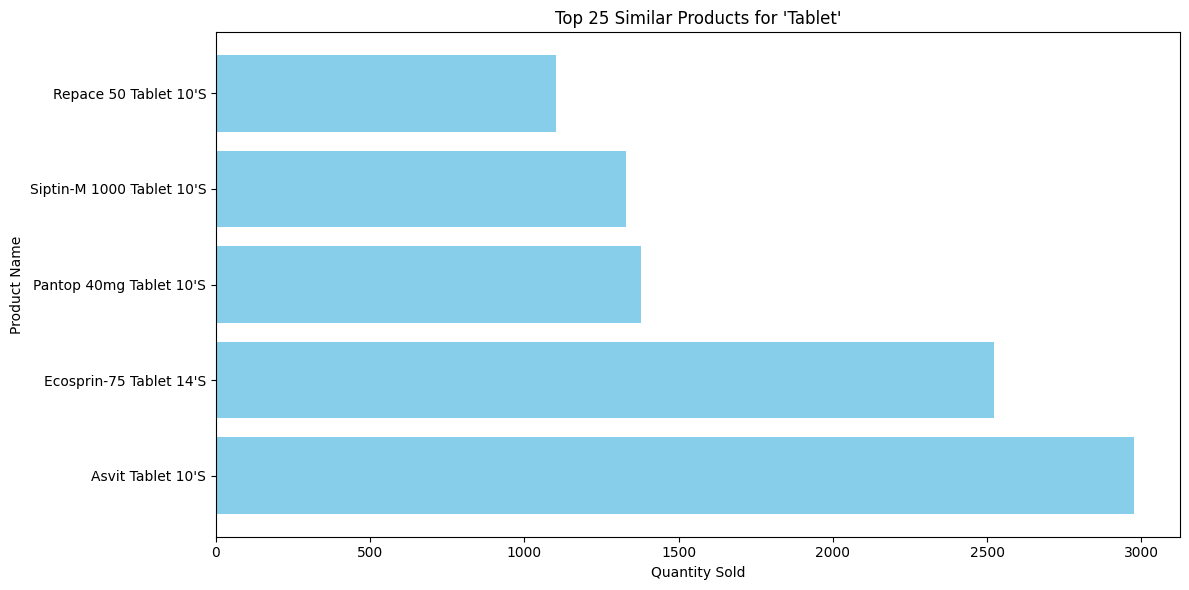

In [80]:
# Visualize the data using a bar chart
def visualize_similar_products(top_similar_products, search_term):
    # Plotting bar chart for top similar products
    plt.figure(figsize=(12, 6))
    plt.barh(top_similar_products['product_name'], top_similar_products['quantity'], color='skyblue')

    # Adding labels and title
    plt.xlabel('Quantity Sold')
    plt.ylabel('Product Name')
    plt.title(f"Top 25 Similar Products for '{search_term}'")

    # Display the plot
    plt.tight_layout()
    plt.show()

# Visualize the data
visualize_similar_products(top_similar_products, search_term)

### 4. Find up-sell and cross-sell products.

In [56]:
from mlxtend.frequent_patterns import apriori, association_rules

# Prepare data for Apriori algorithm
basket = df.groupby(['customer_id', 'product_name'])['quantity'].sum().unstack().fillna(0)
basket = basket.map(lambda x: 1 if x > 0 else 0)  # Convert quantities to binary values

# Apply Apriori
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate rules with num_itemsets argument
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5, num_itemsets=100)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [57]:
# Sort rules by lift and display top 100
print("Generated Rules:")

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(100))

Generated Rules:
                                         antecedents  \
0  (Mamaearth Onion Shampoo for Hair Growth and H...   
1  (Mamaearth Onion Hair Oil for Hair Regrowth & ...   

                                         consequents   support  confidence  \
0  (Mamaearth Onion Hair Oil for Hair Regrowth & ...  0.011879    0.480583   
1  (Mamaearth Onion Shampoo for Hair Growth and H...  0.011879    0.365989   

        lift  
0  14.806561  
1  14.806561  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
# Filter rules for Up-Sell Products (higher confidence and lift)
up_sell_rules = rules[(rules['confidence'] > 0.4) & (rules['lift'] > 1.5)].copy()  # Make a copy to avoid the warning

# Clean up the frozenset representation for readability
up_sell_rules.loc[:, 'antecedents'] = up_sell_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
up_sell_rules.loc[:, 'consequents'] = up_sell_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Print in markdown format
print("Up-Sell Products:")
print(up_sell_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_markdown(index=False, numalign="left", colalign="left"))


Up-Sell Products:
|                                                                                          antecedents |                                                                        consequents |   support |   confidence | lift    |
|------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------|-----------|--------------|:--------|
| Mamaearth Onion Shampoo for Hair Growth and Hair Fall Control with Onion Oil and Plant Keratin 250ml | Mamaearth Onion Hair Oil for Hair Regrowth & Hair Fall Control with Redensyl 150ml | 0.011879  | 0.480583     | 14.8066 |


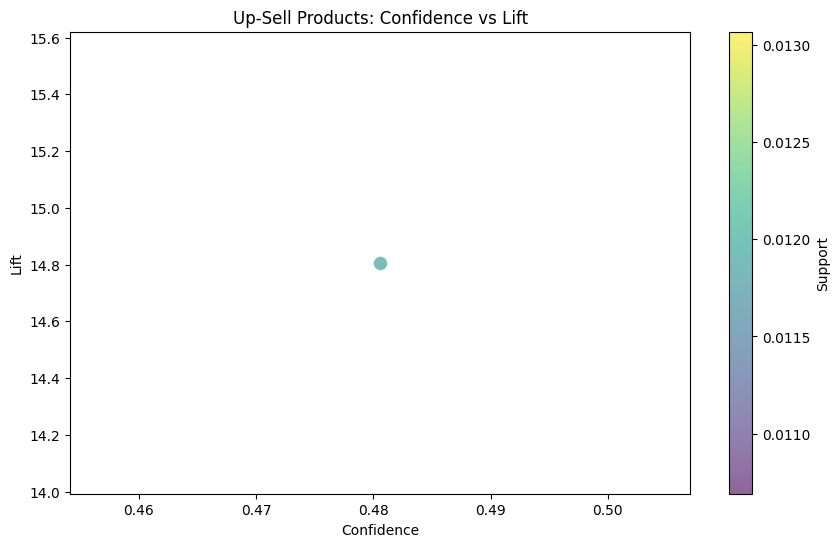

In [87]:
import matplotlib.pyplot as plt

def visualize_up_sell_rules(up_sell_rules):
    if not up_sell_rules.empty:
        # Scatter plot of confidence vs lift
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            up_sell_rules['confidence'], up_sell_rules['lift'],
            c=up_sell_rules['support'], cmap='viridis',
            s=100, alpha=0.6, edgecolors="w", linewidth=0.5
        )

        # Adding color bar to represent the support value
        plt.colorbar(scatter, label='Support')

        # Labels and title
        plt.xlabel('Confidence')
        plt.ylabel('Lift')
        plt.title('Up-Sell Products: Confidence vs Lift')

        # Display the plot
        plt.show()
    else:
        print("No Up-Sell products found based on the given rules.")

# Visualize the Up-Sell products
visualize_up_sell_rules(up_sell_rules)


In [84]:
# Filter rules for Cross-Sell Products (moderate confidence and lift)
cross_sell_rules = rules[(rules['confidence'] > 0.3) & (rules['confidence'] <= 0.7) & (rules['lift'] > 1)]

# Clean up the frozenset representation for readability
cross_sell_rules['antecedents'] = cross_sell_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
cross_sell_rules['consequents'] = cross_sell_rules['consequents'].apply(lambda x: ', '.join(list(x)))

print("Cross-Sell Products:")
print(cross_sell_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10).to_markdown(index=False, numalign="left", colalign="left"))


Cross-Sell Products:
|                                                                                          antecedents |                                                                                          consequents |   support |   confidence | lift    |
|------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------|-----------|--------------|:--------|
| Mamaearth Onion Shampoo for Hair Growth and Hair Fall Control with Onion Oil and Plant Keratin 250ml | Mamaearth Onion Hair Oil for Hair Regrowth & Hair Fall Control with Redensyl 150ml                   | 0.011879  | 0.480583     | 14.8066 |
| Mamaearth Onion Hair Oil for Hair Regrowth & Hair Fall Control with Redensyl 150ml                   | Mamaearth Onion Shampoo for Hair Growth and Hair Fall Control with Onion Oil and Plant Keratin 250ml | 0.011879  | 0.365989     | 14.8066 |

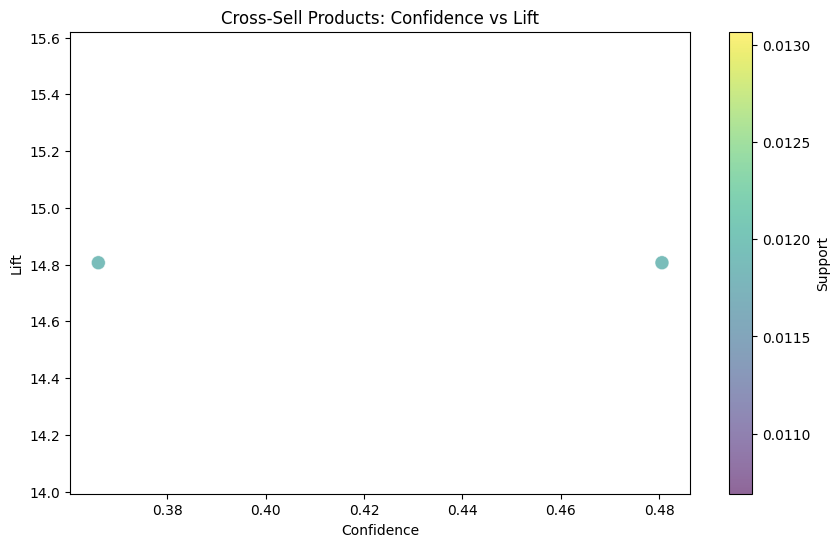

In [88]:
import matplotlib.pyplot as plt

def visualize_cross_sell_rules(cross_sell_rules):
    if not cross_sell_rules.empty:
        # Scatter plot of confidence vs lift for Cross-Sell products
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            cross_sell_rules['confidence'], cross_sell_rules['lift'],
            c=cross_sell_rules['support'], cmap='viridis',
            s=100, alpha=0.6, edgecolors="w", linewidth=0.5
        )

        # Adding color bar to represent the support value
        plt.colorbar(scatter, label='Support')

        # Labels and title
        plt.xlabel('Confidence')
        plt.ylabel('Lift')
        plt.title('Cross-Sell Products: Confidence vs Lift')

        # Display the plot
        plt.show()
    else:
        print("No Cross-Sell products found based on the given rules.")

# Visualize the Cross-Sell products
visualize_cross_sell_rules(cross_sell_rules)
